In [1]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import config as cfg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from utils import build_trip_count, build_distance_count, get_district_names, normalize_by_pop, get_income_data, add_quantiles
sns.set(font_scale=1.2) 

In [2]:
if cfg.type_of_study == 'month':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'all_viajes_month_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during March 2022
    data_name = 'March 2022'
elif cfg.type_of_study == 'week':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'viajes_week_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during a 'normal' week
    data_name = 'Normal Week'
elif cfg.type_of_study == 'two_weeks':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'viajes_two_weeks_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during 2 weeks
    data_name = 'Two Weeks'
elif cfg.type_of_study == 'weekend':
    all_viajes = pd.read_csv(cfg.VIAJES_DATA / 'viajes_weekend_0322.csv', thousands='.',decimal=',')  # Subtracting trips in Madrid districts during 2 weeks
    data_name = 'Weekend'
else:
    raise ValueError('No time of study has been set')

In [3]:
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson') # income data
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson') # geodataframe
gdf = gdf.to_crs(epsg=4326) # setting crs
district_mapping = pd.read_csv('/Users/caro/Desktop/thesis_project/data_overview/outputs/districts_and_population.csv')

In [4]:
all_viajes.shape

(19900955, 15)

In [5]:
all_viajes.actividad_destino.value_counts()

actividad_destino
frecuente          7268863
casa               4933456
no_frecuente       4920539
trabajo_estudio    2778097
Name: count, dtype: int64

In [6]:
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')] # home origin trips

In [7]:
filtered_df.shape

(4839108, 15)

In [8]:
home_work = all_viajes[ # home to work trips
    ((all_viajes['actividad_origen'] == 'casa') & (all_viajes['actividad_destino'] == 'trabajo_estudio'))
]

In [9]:
home_work.shape

(1205740, 15)

## Filtering trips by median income quantile

1. Do low median income quantiles travel more to high median income quantiles for work purposes and overall?
2. Do low median income quantiles travel more distance on average than other median income quantiles for work purposes and overall?

Question 1, all trips with home origin:

In [10]:
# district_counts = filtered_df['origen'].value_counts().reset_index() # OLD
# Group by 'origen' and sum 'viajes'
district_counts = filtered_df.groupby('origen')['viajes'].sum().reset_index(name='total_viajes') # FIXED
district_counts.columns = ['ID', 'Population']

In [11]:
filtered_df[filtered_df['origen'] == 2807901].viajes.sum()

np.int64(136712522521830)

In [12]:
filtered_df.viajes.sum()

np.int64(3298899374979997)

In [13]:
trip_counts = build_trip_count(filtered_df)
trip_counts = get_district_names(trip_counts)
trip_counts = normalize_by_pop(trip_counts, district_counts)
# trip_counts.to_csv(f'outputs/{cfg.type_of_study}_normalized_trip_count.csv', index=False) # saving final df

In [14]:
trip_counts = get_income_data(trip_counts, income, 'Gini Index', 'Median income per consumption unit')
trip_counts = add_quantiles(trip_counts, 'Median income per consumption unit', n_quantiles=4)
trip_counts = add_quantiles(trip_counts, 'Gini Index', n_quantiles=4)

In [15]:
low_to_high_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([0])) & 
                                      (trip_counts['income decile destination Median income per consumption unit'].isin([3]))]

high_to_low_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([3])) & 
                                      (trip_counts['income decile destination Median income per consumption unit'].isin([0]))]

low_to_low_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([0])) &
                                (trip_counts['income decile destination Median income per consumption unit'].isin([0]))]

high_to_high_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([3])) & 
                                trip_counts['income decile destination Median income per consumption unit'].isin([3])]

In [49]:
# percentage of trips from low to high districts (median income per consumtion unit)
# low_to_high_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100

low_to_high_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(3.64631031852065)

In [47]:
# percentage of trips from high to low districts (median income per consumtion unit)
# high_to_low_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100

high_to_low_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(2.3175622940150338)

In [51]:
# low_to_low_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

low_to_low_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(17.66781936100655)

In [44]:
# high_to_high_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

high_to_high_median['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100

np.float64(11.103174809353588)

Question 2, all trips with home origin:

In [137]:
distance_counts = build_distance_count(filtered_df) # adding 'distancia' to the analysis
distance_counts = get_district_names(distance_counts)
distance_counts = get_income_data(distance_counts, income, 'Gini Index', 'Median income per consumption unit')
distance_counts = add_quantiles(distance_counts, 'Median income per consumption unit', n_quantiles=4)
distance_counts = add_quantiles(distance_counts, 'Gini Index', n_quantiles=4)

In [138]:
low_median_income = distance_counts[distance_counts['income decile origin Median income per consumption unit'].isin([0])]
high_median_income = distance_counts[distance_counts['income decile origin Median income per consumption unit'].isin([3])]
low_median_income['Income Group'] = 'Low Income'
high_median_income['Income Group'] = 'High Income'

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/3534028559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_median_income['Income Group'] = 'Low Income'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/3534028559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_median_income['Income Group'] = 'High Income'


In [92]:
low_median_income['distance_per_trip'].describe()

count    126.000000
mean       2.092648
std        3.550954
min        0.340294
25%        0.823477
50%        0.990835
75%        1.178144
max       18.414045
Name: distance_per_trip, dtype: float64

In [93]:
high_median_income['distance_per_trip'].describe()

count    105.000000
mean       1.681308
std        2.434215
min        0.056194
25%        0.842061
50%        1.021718
75%        1.227480
max       14.147028
Name: distance_per_trip, dtype: float64

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/3754152612.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Income Group', y='distance_per_trip', data=combined_df, palette='Set2')


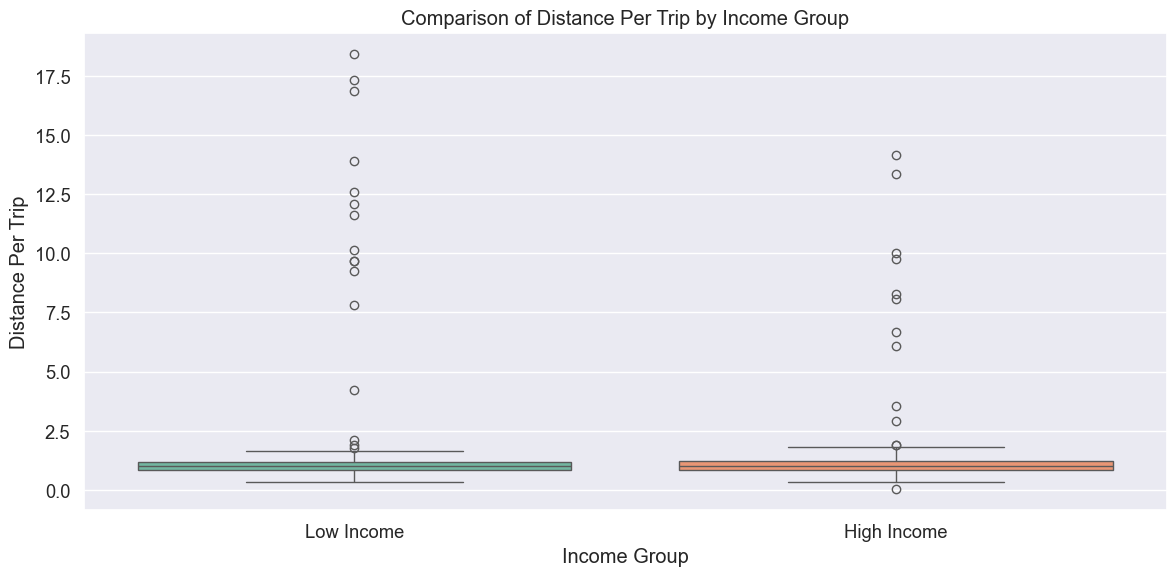

In [99]:
combined_df = pd.concat([low_median_income, high_median_income])

# Plot the distribution of distance_per_trip
plt.figure(figsize=(12, 6))
sns.boxplot(x='Income Group', y='distance_per_trip', data=combined_df, palette='Set2')

plt.title('Comparison of Distance Per Trip by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Distance Per Trip')
plt.tight_layout()

# Save and show the plot
plt.savefig(cfg.FIGURES_PATH / '2_quantiles_distance_per_trip_median.png', dpi=300)
plt.show()

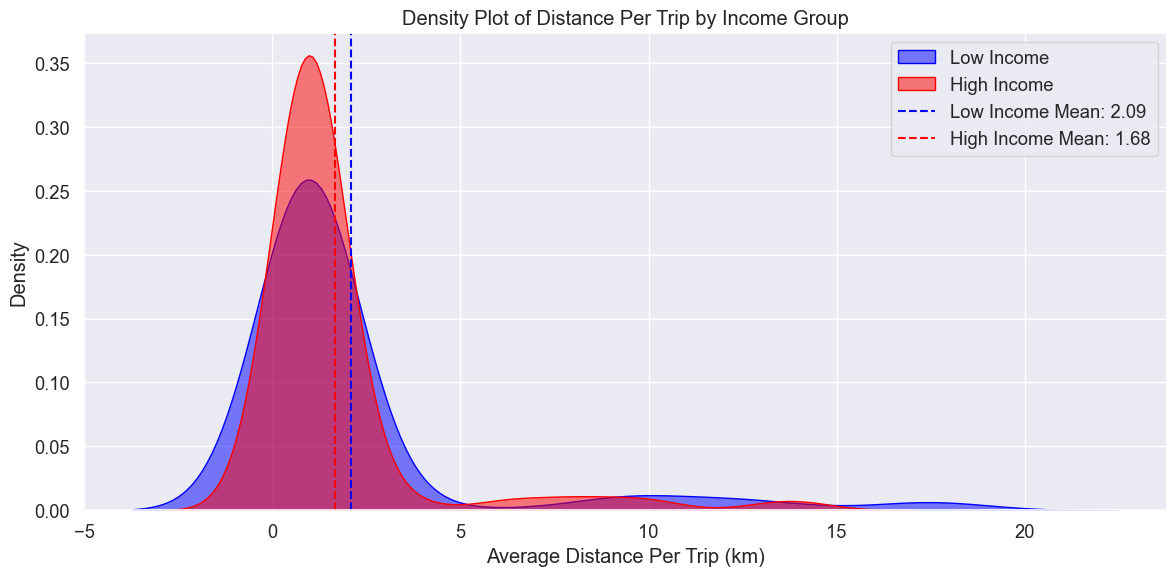

In [53]:
plt.figure(figsize=(12, 6))
sns.kdeplot(low_median_income['distance_per_trip'], label='Low Income', fill=True, color='blue', alpha=0.5)
sns.kdeplot(high_median_income['distance_per_trip'], label='High Income', fill=True, color='red', alpha=0.5)

low_median_mean = low_median_income['distance_per_trip'].mean()
high_median_mean = high_median_income['distance_per_trip'].mean()

plt.axvline(low_median_mean, color='blue', linestyle='--', label=f'Low Income Mean: {low_median_mean:.2f}')
plt.axvline(high_median_mean, color='red', linestyle='--', label=f'High Income Mean: {high_median_mean:.2f}')

plt.title('Density Plot of Distance Per Trip by Income Group')
plt.xlabel('Average Distance Per Trip (km)')
plt.ylabel('Density')
plt.legend()
# plt.savefig(cfg.FIGURES_PATH / '2_quantiles_distance_per_trip_median_density_plot.png', dpi=300)
plt.tight_layout()
plt.show()

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/43955498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_median_income['Income Group'] = 'Low Income'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/43955498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_median_income['Income Group'] = 'High Income'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/43955498.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

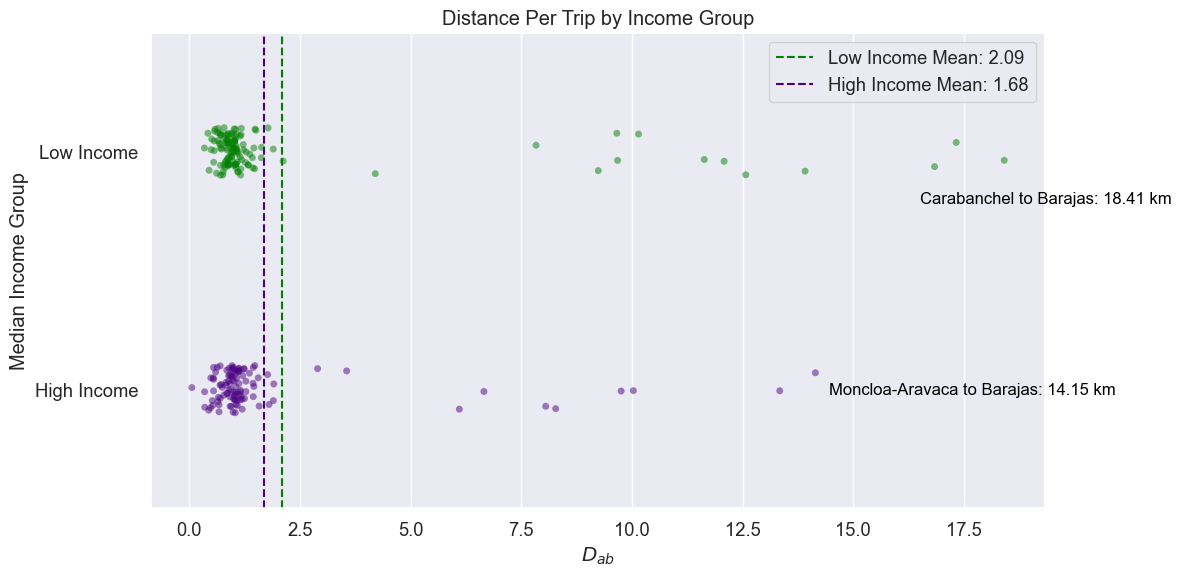

In [148]:
plt.figure(figsize=(12, 6))

# Combine data into a single DataFrame for easier plotting
low_median_income['Income Group'] = 'Low Income'
high_median_income['Income Group'] = 'High Income'
combined_df = pd.concat([low_median_income, high_median_income])

# Use a strip plot to represent the distances
sns.stripplot(
    x='distance_per_trip', 
    y='Income Group', 
    data=combined_df, 
    jitter=True, 
    alpha=0.5, 
    palette={'Low Income': 'green', 'High Income': 'indigo'}
)

# Add mean lines for each group
low_median_mean = low_median_income['distance_per_trip'].mean()
high_median_mean = high_median_income['distance_per_trip'].mean()

longest_trip = low_median_income.loc[low_median_income['distance_per_trip'].idxmax()]
origin = longest_trip['origin']
destination = longest_trip['destination']
distance = longest_trip['distance_per_trip']

longest_trip_high = high_median_income.loc[high_median_income['distance_per_trip'].idxmax()]
origin_high = longest_trip_high['origin']
destination_high = longest_trip_high['destination']
distance_high = longest_trip_high['distance_per_trip']

plt.annotate(
    f'{origin_high} to {destination_high}: {distance_high:.2f} km',
    xy=(distance_high, longest_trip_high['Income Group']),
    xytext=(distance_high + 0.3, 1.02),  # Adjust the label position
    fontsize=12,
    color='black'
)

plt.annotate(
    f'{origin} to {destination}: {distance:.2f} km',
    xy=(distance, longest_trip['Income Group']),
    xytext=(distance - 1.9, 0.2),  # Position text close to the dot
    ha='left',  # Align text horizontally to the left of the anchor point
    va='center',  # Align text vertically centered
    fontsize=12,
    color='black'
)

plt.axvline(low_median_mean, color='green', linestyle='--', label=f'Low Income Mean: {low_median_mean:.2f}')
plt.axvline(high_median_mean, color='indigo', linestyle='--', label=f'High Income Mean: {high_median_mean:.2f}')

plt.title('Distance Per Trip by Income Group')
plt.xlabel(r'$D_{ab}$')
plt.ylabel('Median Income Group')
plt.legend()
plt.tight_layout()
plt.savefig(cfg.FIGURES_PATH / '2_quantiles_distance_per_trip_median_strip_plot.png', dpi=300)
plt.show()


## Filtering trips by Gini Index quantile

Question 1, all trips with home origin, Gini Index:

In [31]:
trip_counts = build_trip_count(filtered_df)
trip_counts = get_district_names(trip_counts)
trip_counts = normalize_by_pop(trip_counts, district_counts)
trip_counts = get_income_data(trip_counts, income, 'Gini Index', 'Median income per consumption unit')
trip_counts = add_quantiles(trip_counts, 'Median income per consumption unit', n_quantiles=4)
trip_counts = add_quantiles(trip_counts, 'Gini Index', n_quantiles=4)

In [32]:
low_to_high_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([0])) & 
                                      (trip_counts['income decile destination Gini Index'].isin([3]))]

high_to_low_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([3])) & 
                                      (trip_counts['income decile destination Gini Index'].isin([0]))]

low_to_low_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([0])) &
                              (trip_counts['income decile destination Gini Index'].isin([0]))]


high_to_high_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([3])) & 
                                (trip_counts['income decile destination Gini Index'].isin([3]))]

In [33]:
# percentage of trips from low to high districts (gini index)
# low_to_high_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

low_to_high_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(4.6977424445309754)

In [34]:
# percentage of trips from high to low districts (gini index)
# high_to_low_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

high_to_low_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(2.8489058353073005)

In [35]:
# low_to_low_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

low_to_low_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(14.908939484809133)

In [36]:
# high_to_high_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

high_to_high_gini['normalized_trip_count'].sum() / trip_counts.normalized_trip_count.sum() * 100 

np.float64(12.579799790036347)

Question 2, all trips with home origin, Gini Index:

In [37]:
distance_counts = build_distance_count(filtered_df)
distance_counts = get_district_names(distance_counts)
distance_counts = get_income_data(distance_counts, income, 'Gini Index', 'Median income per consumption unit')
distance_counts = add_quantiles(distance_counts, 'Median income per consumption unit', n_quantiles=4)
distance_counts = add_quantiles(distance_counts, 'Gini Index', n_quantiles=4)

In [38]:
low_gini = distance_counts[distance_counts['income decile origin Gini Index'].isin([0])]
high_gini = distance_counts[distance_counts['income decile origin Gini Index'].isin([3])]
low_gini['Gini Group'] = 'Low Gini'
high_gini['Gini Group'] = 'High Gini'

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/609701315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_gini['Gini Group'] = 'Low Gini'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/609701315.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_gini['Gini Group'] = 'High Gini'


In [39]:
low_gini['distance_per_trip'].describe()

count    126.000000
mean       2.332864
std        3.436313
min        0.322002
25%        0.829488
50%        1.040986
75%        1.463604
max       17.329573
Name: distance_per_trip, dtype: float64

In [40]:
high_gini['distance_per_trip'].describe()

count    105.000000
mean       1.695936
std        2.434191
min        0.056194
25%        0.844697
50%        1.034071
75%        1.239300
max       14.147028
Name: distance_per_trip, dtype: float64

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/4025401636.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gini Group', y='distance_per_trip', data=combined_df, palette='Set2')


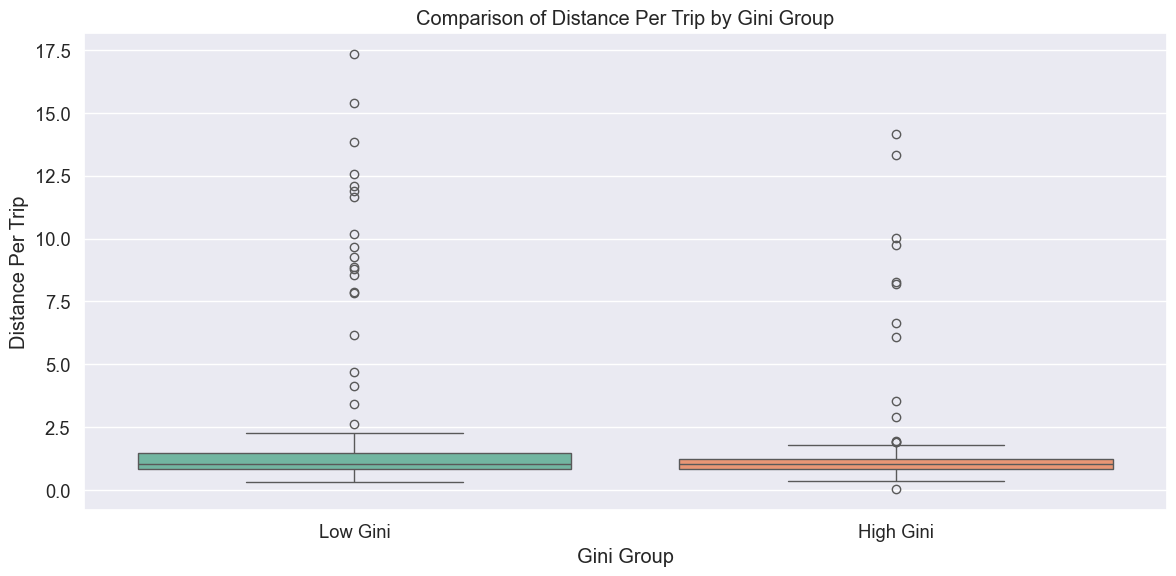

In [111]:
combined_df = pd.concat([low_gini, high_gini])

# Plot the distribution of distance_per_trip
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gini Group', y='distance_per_trip', data=combined_df, palette='Set2')

plt.title('Comparison of Distance Per Trip by Gini Group')
plt.xlabel('Gini Group')
plt.ylabel('Distance Per Trip')
plt.tight_layout()

# Save and show the plot
plt.savefig(cfg.FIGURES_PATH / '2_quantiles_distance_per_trip_gini.png', dpi=300)
plt.show()

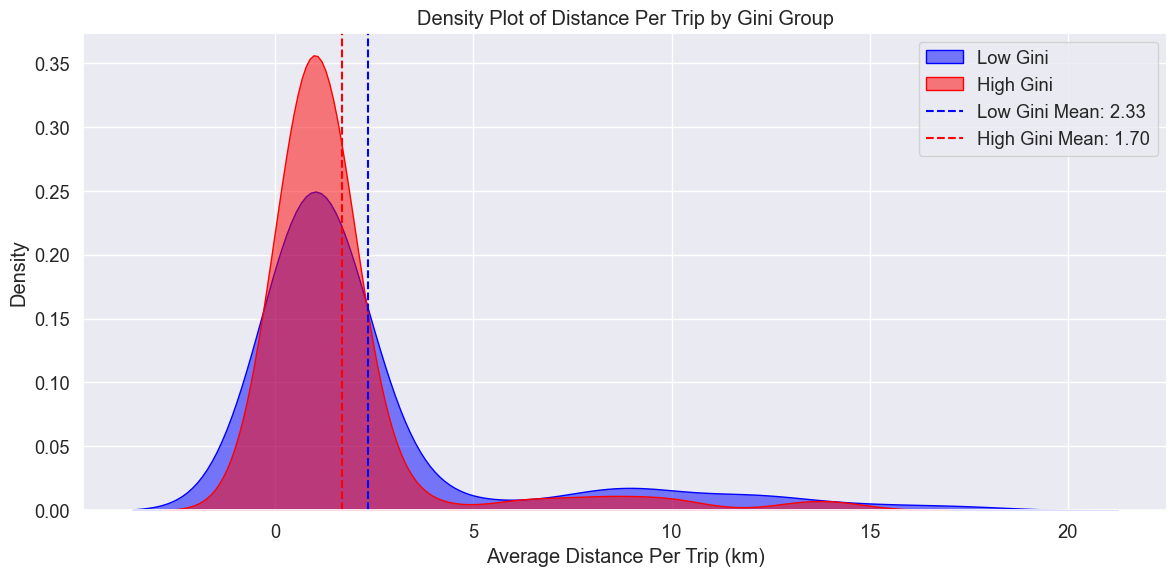

In [41]:
plt.figure(figsize=(12, 6))
sns.kdeplot(low_gini['distance_per_trip'], label='Low Gini', fill=True, color='blue', alpha=0.5)
sns.kdeplot(high_gini['distance_per_trip'], label='High Gini', fill=True, color='red', alpha=0.5)

low_gini_mean = low_gini['distance_per_trip'].mean()
high_gini_mean = high_gini['distance_per_trip'].mean()

plt.axvline(low_gini_mean, color='blue', linestyle='--', label=f'Low Gini Mean: {low_gini_mean:.2f}')
plt.axvline(high_gini_mean, color='red', linestyle='--', label=f'High Gini Mean: {high_gini_mean:.2f}')

plt.title('Density Plot of Distance Per Trip by Gini Group')
plt.xlabel('Average Distance Per Trip (km)')
plt.ylabel('Density')
plt.legend()
plt.savefig(cfg.FIGURES_PATH / '2_quantiles_distance_per_trip_gini_density.png', dpi=300)
plt.tight_layout()
plt.show()

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/3694442204.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


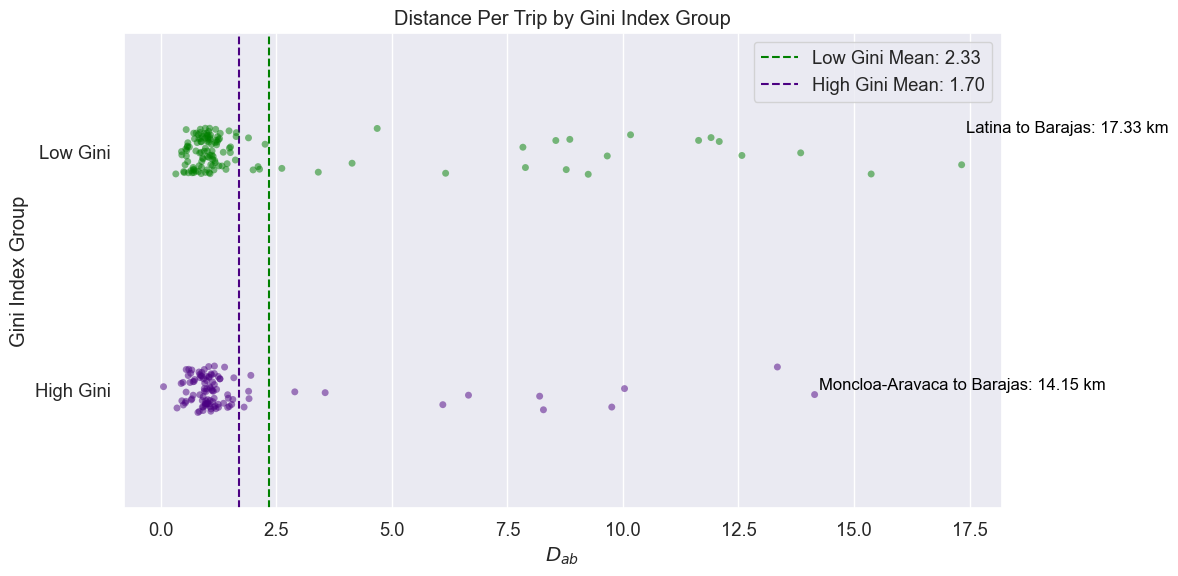

In [150]:
plt.figure(figsize=(12, 6))

# Combine data into a single DataFrame for easier plotting
low_gini['Income Group'] = 'Low Gini'
high_gini['Income Group'] = 'High Gini'
combined_df = pd.concat([low_gini, high_gini])

# Use a strip plot to represent the distances
sns.stripplot(
    x='distance_per_trip', 
    y='Gini Group', 
    data=combined_df, 
    jitter=True, 
    alpha=0.5, 
    palette={'Low Gini': 'green', 'High Gini': 'indigo'}
)

# Add mean lines for each group
low_gini_mean = low_gini['distance_per_trip'].mean()
high_gini_mean = high_gini['distance_per_trip'].mean()

longest_trip = combined_df.loc[combined_df['distance_per_trip'].idxmax()]
origin = longest_trip['origin']
destination = longest_trip['destination']
distance = longest_trip['distance_per_trip']

longest_trip_high = high_gini.loc[high_gini['distance_per_trip'].idxmax()]
origin_high = longest_trip_high['origin']
destination_high = longest_trip_high['destination']
distance_high = longest_trip_high['distance_per_trip']

plt.annotate(
    f'{origin_high} to {destination_high}: {distance_high:.2f} km',
    xy=(distance_high, longest_trip_high['Gini Group']),
    xytext=(distance_high + 0.1, 1),  # Adjust the label position
    fontsize=12,
    color='black'
)

plt.annotate(
    f'{origin} to {destination}: {distance:.2f} km',
    xy=(distance, longest_trip['Gini Group']),
    xytext=(distance + 0.1, -0.1),  # Position text close to the dot
    ha='left',  # Align text horizontally to the left of the anchor point
    va='center',  # Align text vertically centered
    fontsize=12,
    color='black'
)
plt.axvline(low_gini_mean, color='green', linestyle='--', label=f'Low Gini Mean: {low_gini_mean:.2f}')
plt.axvline(high_gini_mean, color='indigo', linestyle='--', label=f'High Gini Mean: {high_gini_mean:.2f}')

plt.title('Distance Per Trip by Gini Index Group')
plt.xlabel(r'$D_{ab}$')
plt.ylabel('Gini Index Group')
plt.legend()
plt.tight_layout()
plt.savefig(cfg.FIGURES_PATH / '2_quantiles_distance_per_trip_gini_strip_plot.png', dpi=300)
plt.show()

## Further Analysis

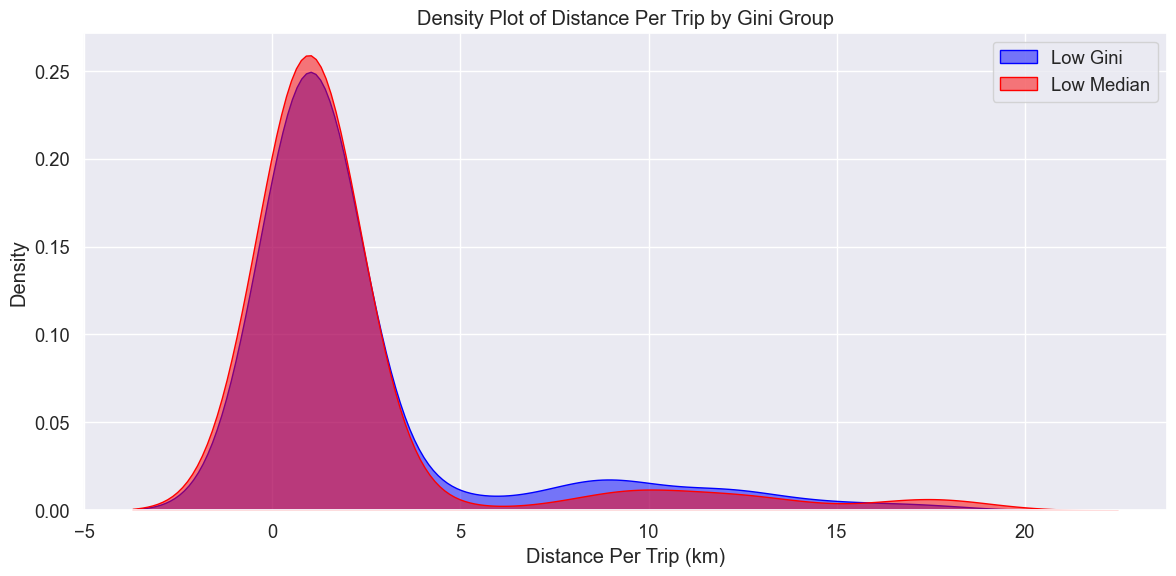

In [113]:
plt.figure(figsize=(12, 6))
sns.kdeplot(low_gini['distance_per_trip'], label='Low Gini', fill=True, color='blue', alpha=0.5)
sns.kdeplot(low_median_income['distance_per_trip'], label='Low Median', fill=True, color='red', alpha=0.5)

plt.title('Density Plot of Distance Per Trip by Gini Group')
plt.xlabel('Distance Per Trip (km)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

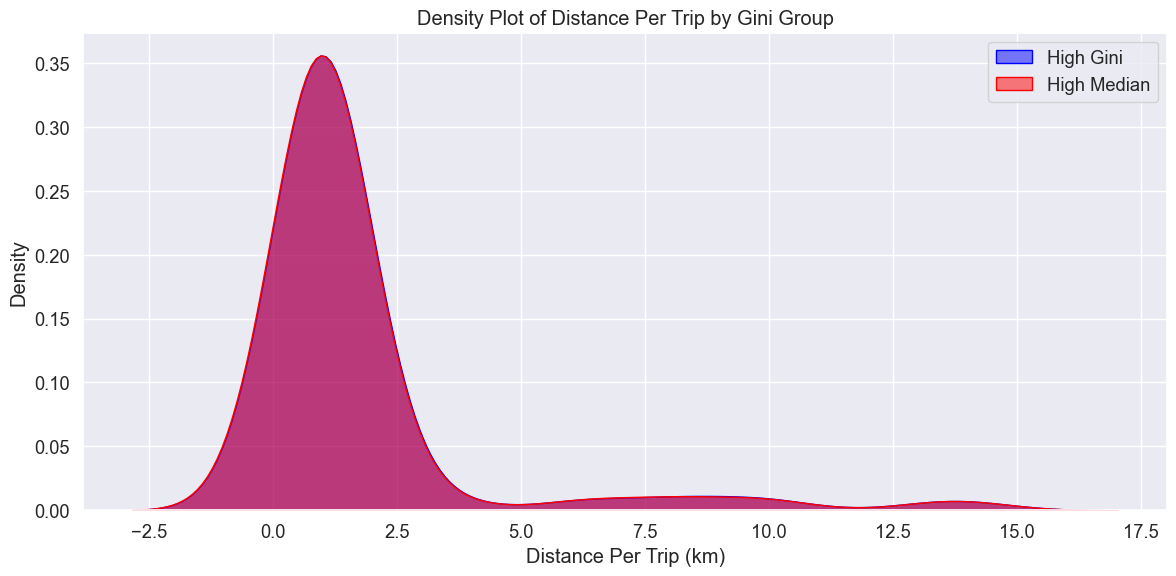

In [114]:
plt.figure(figsize=(12, 6))
sns.kdeplot(high_gini['distance_per_trip'], label='High Gini', fill=True, color='blue', alpha=0.5)
sns.kdeplot(high_median_income['distance_per_trip'], label='High Median', fill=True, color='red', alpha=0.5)

plt.title('Density Plot of Distance Per Trip by Gini Group')
plt.xlabel('Distance Per Trip (km)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/854097190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_gini['Gini Group'] = 'Low Gini'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/854097190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_gini['Gini Group'] = 'High Gini'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/854097190.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with 

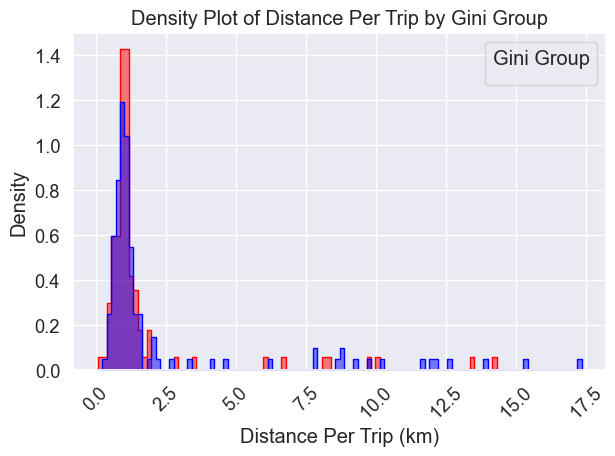

In [115]:
low_gini['Gini Group'] = 'Low Gini'
high_gini['Gini Group'] = 'High Gini'
combined_data = pd.concat([low_gini, high_gini])
sns.histplot(
    data=combined_data,
    x='distance_per_trip',
    hue='Gini Group',
    element='step',  # Step style for clarity
    stat='density',  # Plot density instead of counts
    common_norm=False,  # Separate normalization for each group
    alpha=0.5,  # Transparency for overlapping
    palette={'Low Gini': 'blue', 'High Gini': 'red'}
)

# Adjust labels and titles
plt.title('Density Plot of Distance Per Trip by Gini Group')
plt.xlabel('Distance Per Trip (km)')
plt.ylabel('Density')
plt.legend(title='Gini Group')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/2242638241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_median_income['Median Income Group'] = 'Low Median'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/2242638241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_median_income['Median Income Group'] = 'High Median'
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/2242638241.py:19: UserWarning: No artists with labels found to put in legend.

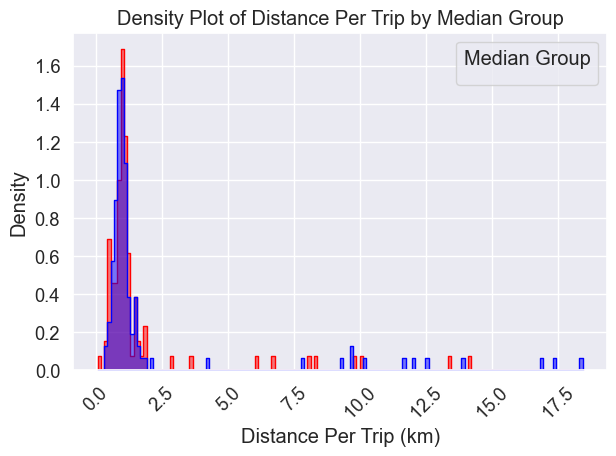

In [116]:
low_median_income['Median Income Group'] = 'Low Median'
high_median_income['Median Income Group'] = 'High Median'
combined_data = pd.concat([low_median_income, high_median_income])
sns.histplot(
    data=combined_data,
    x='distance_per_trip',
    hue='Median Income Group',
    element='step',  # Step style for clarity
    stat='density',  # Plot density instead of counts
    common_norm=False,  # Separate normalization for each group
    alpha=0.5,  # Transparency for overlapping
    palette={'Low Median': 'blue', 'High Median': 'red'}
)

# Adjust labels and titles
plt.title('Density Plot of Distance Per Trip by Median Group')
plt.xlabel('Distance Per Trip (km)')
plt.ylabel('Density')
plt.legend(title='Median Group')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [45]:
low_median_income['distance_per_trip'].describe()

count    126.000000
mean       2.092648
std        3.550954
min        0.340294
25%        0.823477
50%        0.990835
75%        1.178144
max       18.414045
Name: distance_per_trip, dtype: float64

In [46]:
high_median_income['distance_per_trip'].describe()

count    105.000000
mean       1.681308
std        2.434215
min        0.056194
25%        0.842061
50%        1.021718
75%        1.227480
max       14.147028
Name: distance_per_trip, dtype: float64

In [47]:
low_gini['distance_per_trip'].describe()

count    231.000000
mean       2.387281
std        3.686758
min        0.106755
25%        0.829430
50%        1.037744
75%        1.377958
max       18.414045
Name: distance_per_trip, dtype: float64

In [48]:
high_gini['distance_per_trip'].describe()

count    210.000000
mean       1.837338
std        2.762216
min        0.056194
25%        0.867037
50%        1.027217
75%        1.234009
max       14.731944
Name: distance_per_trip, dtype: float64

Compare two distributions: https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets
https://samharrison.science/posts/how-to-compare-two-distributions/

In [49]:
from scipy.stats import ks_2samp, anderson_ksamp

ks_a_b_median = anderson_ksamp([low_median_income['distance_per_trip'], high_median_income['distance_per_trip']])
ks_b_a_median = anderson_ksamp([high_median_income['distance_per_trip'], low_median_income['distance_per_trip']])

ks_a_b_gini = anderson_ksamp([low_gini['distance_per_trip'], high_gini['distance_per_trip']])
ks_b_a_gini = anderson_ksamp([high_gini['distance_per_trip'], low_gini['distance_per_trip']])

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/2518939952.py:3: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ks_a_b_median = anderson_ksamp([low_median_income['distance_per_trip'], high_median_income['distance_per_trip']])
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/2518939952.py:4: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ks_b_a_median = anderson_ksamp([high_median_income['distance_per_trip'], low_median_income['distance_per_trip']])
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_34235/2518939952.py:6: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ks_a_b_gini = anderson_ksamp([low_gini['distance_per_trip'], high_gini['distance_per_trip']])
/var/folders/5y/mx06x73d0yb7mfb57y7l

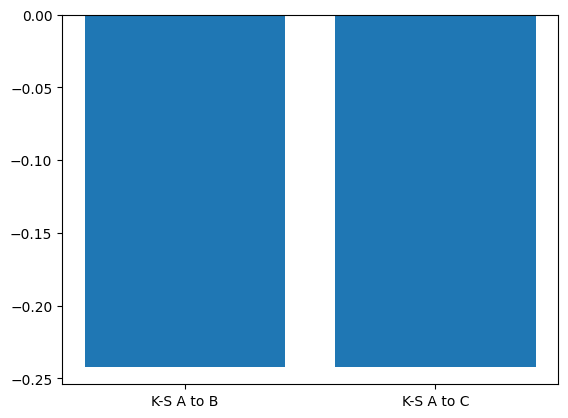

In [50]:
plt.bar(['K-S A to B', 'K-S A to C'],
        [ks_a_b_median.statistic, ks_b_a_median.statistic])
plt.show()

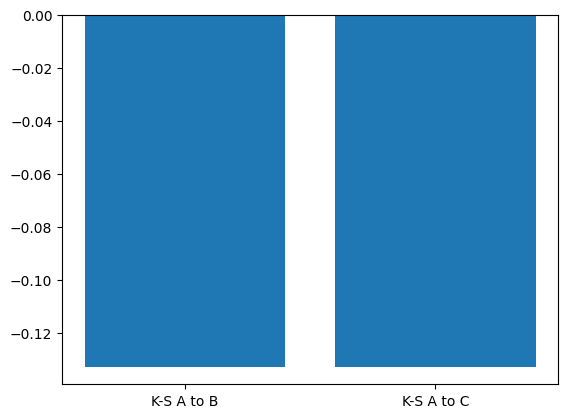

In [51]:
plt.bar(['K-S A to B', 'K-S A to C'],
        [ks_a_b_gini.statistic, ks_b_a_gini.statistic])
plt.show()

In [104]:
top_distance = distance_counts.nlargest(5, 'distance_per_trip')
least_distance = distance_counts.nsmallest(5, 'distance_per_trip')

In [106]:
top_distance

,viajes_km,viajes,distance_per_trip,origin,destination,Origin Gini Index,Origin Median income per consumption unit,Destination Gini Index,Destination Median income per consumption unit,income decile origin Median income per consumption unit,income decile destination Median income per consumption unit,income decile origin Gini Index,income decile destination Gini Index
230,724291629870,39333651422,18.414045,Carabanchel,Barajas,33.1,15750,33.2,25550,0,2,1,1
209,619793763,35765092,17.329573,Latina,Barajas,31.8,17850,33.2,25550,0,2,0,1
436,59652751,3455182,17.264720,Barajas,Villaverde,33.2,25550,31.9,15050,2,0,1,1
356,454708252,27001661,16.840010,Villaverde,Barajas,31.9,15050,33.2,25550,0,2,1,1
430,72619639,4390336,16.540793,Barajas,Carabanchel,33.2,25550,33.1,15750,2,0,1,1


In [103]:
filtered_df

,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km
0,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,hombre,29337,30222
1,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,mujer,34143,27522
2,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,hombre,92799,63331
3,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,mujer,65475,44556
4,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,45-65,hombre,44319,31052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19900884,20220331,23,2807921,2807921,2-10,casa,no_frecuente,no,no,28,>15,25-45,mujer,34,7835
19900885,20220331,23,2807921,2807921,2-10,casa,no_frecuente,no,no,28,>15,45-65,hombre,2005,9351
19900886,20220331,23,2807921,2807921,2-10,casa,trabajo_estudio,no,no,28,>15,25-45,hombre,494,12918
19900887,20220331,23,2807921,2807921,2-10,casa,trabajo_estudio,no,no,28,>15,45-65,hombre,401,9502


## Stratifying by rent

In [107]:
distance_counts = build_distance_count(filtered_df)
distance_counts = get_district_names(distance_counts)
distance_counts = get_income_data(distance_counts, income, 'Gini Index', 'Median income per consumption unit')
distance_counts = add_quantiles(distance_counts, 'Median income per consumption unit', n_quantiles=4)
distance_counts = add_quantiles(distance_counts, 'Gini Index', n_quantiles=4)

In [108]:
distance_counts

,origen,destino,viajes_km,viajes,distance_per_trip,origin,destination
0,2807901,2807901,26266415152375,24324971550694,1.079813,Centro,Centro
1,2807901,2807902,19297124157848,18484663675589,1.043953,Centro,Arganzuela
2,2807901,2807903,10009632888723,9149580288556,1.093999,Centro,Retiro
3,2807901,2807904,6886099976708,5956602526113,1.156045,Centro,Salamanca
4,2807901,2807905,2338622524232,2407389146007,0.971435,Centro,Chamartín
...,...,...,...,...,...,...,...
436,2807921,2807917,59652751,3455182,17.264720,Barajas,Villaverde
437,2807921,2807918,75704580,6276638,12.061326,Barajas,Villa de Vallecas
438,2807921,2807919,13271955445,124321622892,0.106755,Barajas,Vicálvaro
439,2807921,2807920,22691886908929,20348620894106,1.115156,Barajas,San Blas-Canillejas


In [109]:
filtered_df[filtered_df['renta'] == ">15"]['viajes_km'].sum()

np.int64(1979599116816693)

In [110]:
filtered_df

,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km
0,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,hombre,29337,30222
1,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,mujer,34143,27522
2,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,hombre,92799,63331
3,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,mujer,65475,44556
4,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,45-65,hombre,44319,31052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19900884,20220331,23,2807921,2807921,2-10,casa,no_frecuente,no,no,28,>15,25-45,mujer,34,7835
19900885,20220331,23,2807921,2807921,2-10,casa,no_frecuente,no,no,28,>15,45-65,hombre,2005,9351
19900886,20220331,23,2807921,2807921,2-10,casa,trabajo_estudio,no,no,28,>15,25-45,hombre,494,12918
19900887,20220331,23,2807921,2807921,2-10,casa,trabajo_estudio,no,no,28,>15,45-65,hombre,401,9502


/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_46595/4095906757.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="Income Group", y="km_per_trip", data=combined_df, palette={"High Income": "blue", "Low Income": "red"})


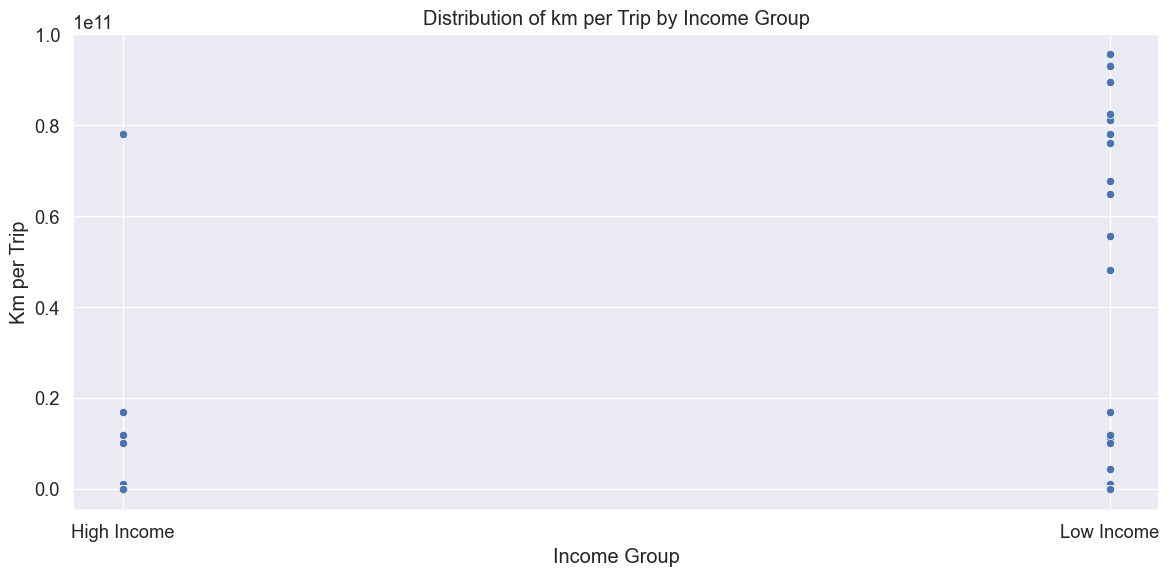

In [115]:
high_income = filtered_df[filtered_df["sexo"] > 'hombre'].copy()
low_income = filtered_df[filtered_df["sexo"] <= 'mujer'].copy()

# Calculate km per trip
high_income["km_per_trip"] = high_income["viajes_km"] / high_income["viajes"]
low_income["km_per_trip"] = low_income["viajes_km"] / low_income["viajes"]

# Combine data for visualization
high_income["Income Group"] = "High Income"
low_income["Income Group"] = "Low Income"
combined_df = pd.concat([high_income, low_income])

# Plot distributions
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Income Group", y="km_per_trip", data=combined_df, palette={"High Income": "blue", "Low Income": "red"})
plt.title("Distribution of km per Trip by Income Group")
plt.xlabel("Income Group")
plt.ylabel("Km per Trip")
plt.tight_layout()
plt.show()